### This test notebook contains code to create an endpoint, evaluate on a test dataset, generate predictions and calculate metrics.

In [ ]:
#Run the utility notebook
%run utils.py

### Choose the model you want to use in this test
- Make sure to choose a model based on the naming conventions of the outputted model files from the train notebook **nb_train.ipynb**

In [ ]:
MODEL = "data-train-email-types-yyyy-mm-dd-a"

### Setup where to store/access data files
- Access all testing data files: https://us-east-1.console.aws.amazon.com/s3/buckets/sigparser-models?region=us-east-1&bucketType=general&prefix=email-types-distilBERT/&showversions=false
- IMPORTANT: Make sure this naming convention is used (e.g. **data-test-email-types-yyyy-mm-dd-a.csv**)

In [ ]:
#The INPUT will change every time we run this notebook with a new dataset
INPUT = "data-test-email-types-yyyy-mm-dd-a.csv.csv"
OUTPUT = INPUT.removesuffix(".csv")

print(f"INPUT: {INPUT}")
print(f"OUTPUT: {OUTPUT}")

#These values won't change unless we change the structure of our S3 bucket
S3_BUCKET_NAME = 'sigparser-models'
S3_FOLDER_NAME = 'email-types-distilBERT'

### Clean the raw training data (IMPORTANT: Make sure you uploaded the training data on the S3 bucket in the previous step)

In [ ]:
test_df = retrieve_from_s3(bucket_name=S3_BUCKET_NAME, file_key=f"{S3_FOLDER_NAME}/{INPUT}")
print(f"Number of rows in the test dataset: {len(test_df)}")

In [ ]:
EMAIL_TYPE_COL = "Email Type"
EMAIL_ADDRESS_COL = "Email Address"
EMAIL_NAME_COL = "Email Name"
EMAIL_DISPLAY_NAME_COL = "Email Display Name"

print("Shape of test dataframe: ", test_df.shape)

nan_values(test_df)

#Convert Email Type str values to 'LABEL_0' for Person and 'LABEL_1' for Non-Person to ensure compatibility with the way the model has mapped numeric labels while training to a more descriptive string format for outputs
test_df[EMAIL_TYPE_COL] = test_df[EMAIL_TYPE_COL].apply(lambda x: 'LABEL_0' if x == 'Person' else 'LABEL_1')

#Concatenating the email columns
test_df['combined'] = test_df[EMAIL_ADDRESS_COL]+ ', ' +test_df[EMAIL_NAME_COL]+ ', ' +test_df[EMAIL_DISPLAY_NAME_COL]

#Picking out only the  combined string column to be in the test df and the numeric values to be in ground truth list
test_df_distilbert = test_df[['combined']]
gt_df_distilbert = test_df[[EMAIL_TYPE_COL]].rename(columns={EMAIL_TYPE_COL: 'gt'})

save_to_s3(test_df_distilbert, bucket_name=S3_BUCKET_NAME, file_key=f"{S3_FOLDER_NAME}/{OUTPUT}/test_data.csv", mode="test")
save_to_s3(gt_df_distilbert, bucket_name=S3_BUCKET_NAME, file_key=f"{S3_FOLDER_NAME}/{OUTPUT}/distilbert_test_gt.csv", mode="test")

### Starting a SageMaker session with boto3

In [15]:
sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

### Creating endpoint configuration and real-time inference endpoint

In [ ]:
model_path=f"s3://{S3_BUCKET_NAME}/{MODEL}/{MODEL}-model/output/model.tar.gz"
time_taken = 0 

### Provide existing endpoint of endpoint to use (If one already exists)
- access existing endpoints here: https://us-east-1.console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints

In [ ]:
ENDPOINT = ""

### (OPTIONAL): Create and activate new model Endpoint

In [105]:
NEW_ENDPOINT_NAME = "distilbert-base-multilingual-cased-24-04-2024-b"

print("Endpoint name not given, creating endpoint")

start_time = time.time() #Recording the time of starting endpoint creation
create_endpoint(instance_type="ml.m5.xlarge", endpoint_name=NEW_ENDPOINT_NAME, 
                model_data=model_path, aws_role=aws_role)
end_time = time.time()  #Recording the time after creating the endpoint
time_taken = end_time - start_time  

print("Time taken to create endpoint: ", time_taken)
print("Time taken to create endpoint: ", time_taken)

ENDPOINT = NEW_ENDPOINT_NAME

Using model 'huggingface-tc-distilbert-base-multilingual-cased' with wildcard version identifier '*'. You can pin to version '2.0.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


Endpoint name not given, creating endpoint
Model data location given:  s3://sagemaker-sigparser-caylent-mlops/data/email-type/output/DistilBERT/model_data/distilbert-tc-base-multilingual-cased-2024-04-23-19-06-45-054/output/model.tar.gz
-----------!Time taken to create endpoint:  416.7927587032318


### Load test dataset and ground truth labels from S3

In [107]:
test_data_key = f"{S3_FOLDER_NAME}/{OUTPUT}/test_data.csv"
ground_truth_key = f"{S3_FOLDER_NAME}/{OUTPUT}/distilbert_test_gt.csv"
test_list, gt = test_dataset(S3_BUCKET_NAME, test_data_key, ground_truth_key)

In [108]:
len_test = len(test_list)
print("Number of items in test dataset: ", len_test)

Number of items in test dataset:  53646


### Getting predictions from endpoint while calculating the total time taken

In [109]:
#Creating a Predictor object with the endpoint's name
finetuned_predictor = Predictor(endpoint_name=ENDPOINT)

In [110]:
#Calculate predictions for test dataset using endpoint
predictions = []
probabilities_person = []
probabilities_non_person = []
total_time_taken = 0 

for idx, text in tqdm(enumerate(test_list), total = len_test, desc = "Generating predictions"): #The 'total' parameter specifies the total number of iterations that the progress bar should expect
    start_time = time.time()  #Recording the time before sending the request to the endpoint
    
    query_response = query_endpoint(finetuned_predictor, text) #You can encode with utf-8 here
    end_time = time.time()  #Recording the time after receiving the response from the endpoint
    time_taken = end_time - start_time  
    total_time_taken += time_taken
    
    probabilities, labels, predicted_label = parse_response(query_response)
    if probabilities[1] >= 0.9:
        predicted_label = 'LABEL_1' #Non-Person
    else:
        predicted_label = 'LABEL_0' #Person
    predictions.append(predicted_label)
    probabilities_person.append(probabilities[0]) 
    probabilities_non_person.append(probabilities[1]) 

print(f"Total time taken for {len_test} predictions: {total_time_taken} seconds")
average_time_per_prediction = total_time_taken / len_test
print(f"Average time taken per prediction: {average_time_per_prediction} seconds")


#Save prediction results to S3
all_predictions_df = save_predictions(test_list, gt, predictions, probabilities_person, probabilities_non_person, S3_BUCKET_NAME, 
                     f"{S3_FOLDER_NAME}/{OUTPUT}/all_predictions.csv")

#Save misclassified results to S3
misclassified_pred(all_predictions_df, S3_BUCKET_NAME, f"{S3_FOLDER_NAME}/{OUTPUT}/misclassified_predictions.csv")

Generating predictions: 100%|██████████| 53646/53646 [14:44<00:00, 60.63it/s]

Total time taken for 53646 predictions: 866.2373127937317 seconds
Average time taken per prediction: 0.016147286149829097 seconds


### Metrics to measure the effectiveness of the model on the test dataset

In [113]:
#Calling function to calculate Class-wise precision and recall, and total precision, recall, f1 score and accuracy
#We are storing the numeric format of pred and gt for calculating confusion matrix later
numeric_predictions, numeric_ground_truth, overall_accuracy, precision, recall, f1 = classification_metrics(gt, predictions)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision for Person: 0.0
Recall for Person: 0.0

Precision for Non-Person: 1.0
Recall for Non-Person: 0.07728442008723857

Overall Precision: 0.5
Overall Recall: 0.038642210043619285
F1 Score: 0.07174003322259136

Overall Accuracy: 0.07728442008723857


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [114]:
#Calling function to calculate confusion matrix and class wise accuracy
conf_matrix = confusion_matrix_accuracy(numeric_ground_truth, numeric_predictions)

[[    0     0]
 [49500  4146]]

Accuracy for Person: nan%
Accuracy for Non-Person: 7.73%


/root/LLMParsingModels/experiments/email-type-distilBERT/distilBERT_utility.py:187: RuntimeWarning: invalid value encountered in scalar divide
  person_accuracy = (TN / (TN + FP)) * 100  # Accuracy for "Person"


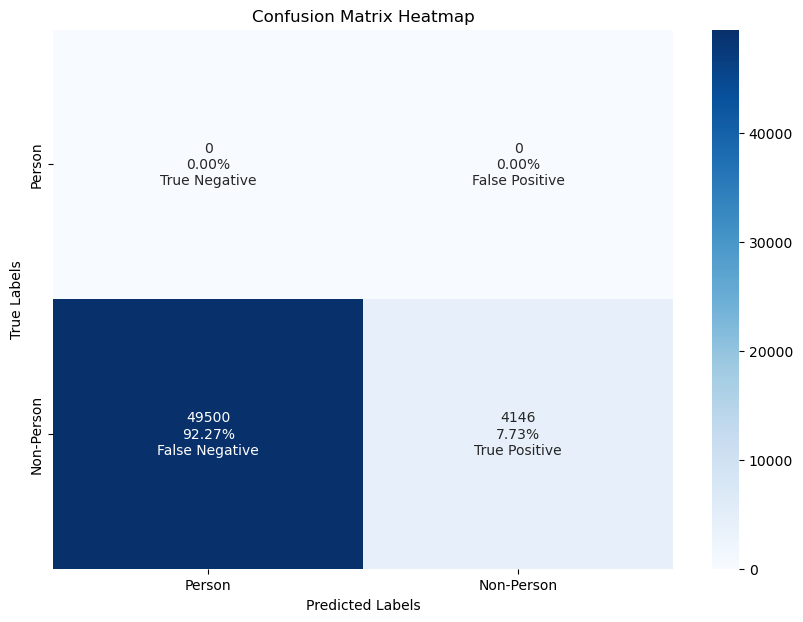

In [115]:
#Calling function to plot heatmap
plot_heatmap(conf_matrix)

In [116]:
#Calling function to print the percentage of total records correctly classified and incorrectly classified according to label
percentage_records_classified(conf_matrix)

Percentage of the total records correctly classified: 7.73%
Percentage of the total records wrongly classified as 'Person' when the True(actual) label is 'Non-Person': 92.27%
Percentage of the overall data wrongly classified as 'Non-Person' when the True(actual) label is 'Person': 0.00%


#### Saving key results and metrics in JSON file

In [117]:
training_dataset_s3_path = f"s3://sagemaker-sigparser-caylent-mlops/data/email-type/input/processed/distilbert/distilbert-fine_tuning-23-04-2024/data.csv"
test_dataset_s3_path = bucket_name+'/'+test_data_key
s3_output_location = f"s3://sagemaker-sigparser-caylent-mlops/data/email-type/output/DistilBERT/23-04-2024/all_predictions.csv"
model_id, model_version = 'huggingface-tc-distilbert-base-multilingual-cased', "2.0.0" 
gt_path = bucket_name+'/'+ground_truth_key

results_summary = {
    "train_data_location": training_dataset_s3_path,  
    "test_data_location":test_dataset_s3_path,
    "ground_truth_location": gt_path,
    "model_id": model_id,
    "model_version": model_version,
    "model_path": model_path,
    "output_data_location": s3_output_location,
    "evaluation_results": {
        "accuracy": overall_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
        }
    }

save_json_to_s3(results_summary, 'sagemaker-sigparser-caylent-mlops', 'data/email-type/output/DistilBERT/23-04-2024/results_summary.json')

The JSON file has been uploaded successfully to the S3 bucket.


## 10k dataset

In [61]:
#Loading test set and ground truth labels
test_data_key = 'data/email-type/input/processed/distilbert/distilbert-test/10k_test_data.csv'
ground_truth_key = 'data/email-type/input/processed/distilbert/distilbert-test/10k_test_gt.csv'
test_list, gt = test_dataset(bucket, test_data_key, ground_truth_key)

In [ ]:
len_test = len(test_list)
print("Number of items in test dataset: ", len_test)

In [37]:
#Calculate predictions for test dataset using endpoint
predictions = []
probabilities_person = []
probabilities_non_person = []
total_time_taken = 0 

for idx, text in tqdm(enumerate(test_list), total = len_test, desc = "Generating predictions"): 
    start_time = time.time()  #Recording the time before sending the request to the endpoint
    
    query_response = query_endpoint(finetuned_predictor, text) #You can encode with utf-8 here
    end_time = time.time()  #Recording the time after receiving the response from the endpoint
    time_taken = end_time - start_time  
    total_time_taken += time_taken
    
    probabilities, labels, predicted_label = parse_response(query_response)
    predictions.append(predicted_label)
    probabilities_person.append(probabilities[0]) 
    probabilities_non_person.append(probabilities[1]) 

print(f"Total time taken for {len_test} predictions: {total_time_taken} seconds")
average_time_per_prediction = total_time_taken / len_test
print(f"Average time taken per prediction: {average_time_per_prediction} seconds")

Total time taken for 10000 predictions: 679.8090829849243 seconds
Average time taken per prediction: 0.06798090829849243 seconds


In [38]:
#Calling function to calculate Class-wise precision and recall, and total precision, recall, f1 score and accuracy
#We are storing the numeric format of pred and gt for calculating confusion matrix later
numeric_predictions, numeric_ground_truth, overall_accuracy, precision, recall, f1 = classification_metrics(gt, predictions)

Precision for Person: 0.9929859719438878
Recall for Person: 0.9937825912555155

Precision for Non Person: 0.993812375249501
Recall for Non Person: 0.993019545273235

Overall Precision: 0.9933991735966944
Overall Recall: 0.9934010682643752
F1 Score: 0.9933999619837811

Overall Accuracy: 0.9934


In [39]:
#Calling function to calculate confusion matrix and class wise accuracy
conf_matrix = confusion_matrix_accuracy(numeric_ground_truth, numeric_predictions)

[[4955   31]
 [  35 4979]]

Accuracy for Person: 99.30%
Accuracy for Non-Person: 99.38%


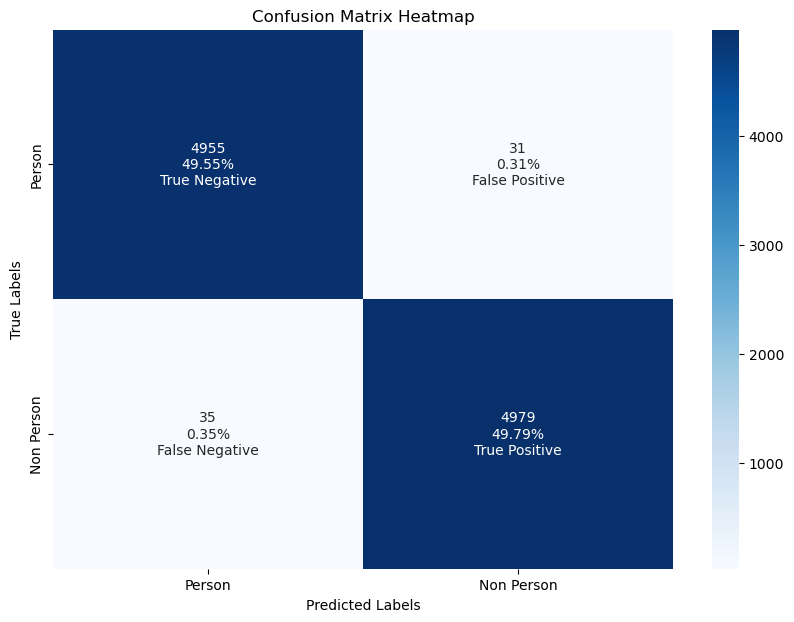

In [40]:
#Calling function to plot heatmap
plot_heatmap(conf_matrix)

In [41]:
#Calling function to print the percentage of total records correctly classified and incorrectly classified according to label
percentage_records_classified(conf_matrix)

Percentage of the total records correctly classified: 99.34%
Percentage of the total records wrongly classified as 'LABEL_0' when the True(actual) label is 'LABEL_1': 0.35%
Percentage of the overall data wrongly classified as 'LABEL_1' when the True(actual) label is 'LABEL_0': 0.31%


In [42]:
#Saving results in json file
training_dataset_s3_path = f"s3://sagemaker-sigparser-caylent-mlops/data/email-type/input/processed/distilbert/distilbert-fine_tuning-08-04-2024/data.csv"
test_dataset_s3_path = bucket_name+'/'+test_data_key
s3_output_location = f"s3://sagemaker-sigparser-caylent-mlops/data/email-type/output/DistilBERT/10k-test-dataset_02-04-2024/misclassified_results_distilbert.csv"
model_id, model_version = 'huggingface-tc-distilbert-base-multilingual-cased', "*" 
gt_path = bucket_name+'/'+ground_truth_key

results_summary = {
    "train_data_location": training_dataset_s3_path,  
    "test_data_location":test_dataset_s3_path,
    "ground_truth_location": gt_path,
    "model_id": model_id,
    "model_version": model_version,
    "model_path": model_path,
    "output_data_location": s3_output_location,
    "evaluation_results": {
        "accuracy": overall_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
}

save_json_to_s3(outfile, 'sagemaker-sigparser-caylent-mlops', 'data/email-type/output/DistilBERT/10k-test-dataset_02-04-2024/results_summary.json')